# Protein Folding

### Introduction

The structure and function of many natural and human-engineered
proteins is still only poorly understood. As a result, our understanding of
processes connected with protein folding, such as those encountered in
Alzheimer’s disease, vaccine development, and crop improvement
research, has remained limited.

Unfolded polypeptides have a very large number of degrees of freedom
and thus an enormous number of potential conformations. For example, a
chain with 100 aminoacids has on the order of 10<sup>47</sup> conformations. In
reality, however, many proteins fold to their native structure within
seconds. This is known as Levinthal’s paradox [1].

The exponential growth of potential conformations with chain length
makes the problem intractable for classical computers. In the quantum
framework, our resource-efficient algorithm scales linearly with
the number of amino acids N.


<font size='2'>[1] https://en.wikipedia.org/wiki/Levinthal%27s_paradox </font>

The goal of this work is to determine the minimum energy conformation of a protein. Starting from a random configuration, the protein's structure is optimized to lower the energy. This can be achieved by encoding the protein folding problem into a qubit operator and ensuring that all physical constrains are satisfied. 

For the problem encoding we use: 

- Configuration qubits: qubits that are used to describe the configurations and the relative position of the different beads
- Interaction qubits: qubits that encode interactions between the different aminoacids

For our case we use a tetrahydral lattice (diamond shape lattice) where we encode the movement through the configuration qubits (see image below). 

<img src="aux_files/lattice_protein.png" width="300">

The Hamiltonian of the system for a set of qubits $\mathbf{q}=\{\mathbf{q}_{cf}, \mathbf{q}_{in}\}$ is 

$$H(\mathbf{q}) = H_{gc}(\mathbf{q}_{cf}) + H_{ch}(\mathbf{q}_{cf}) + H_{in}(\mathbf{q}) $$

where 
- $H_{gc}$ is the geometrical constraint term (governing the growth of the primary sequence of aminoacids without bifurcations
- $H_{ch}$ is the chirality constraint (enforcing the right stereochemistry for the system)
- $H_{in}$ is the interaction energy terms of the system. In our case we consider only nearest neighbor interactions. 

Further details about the used model and the encoding of the problem can be found in [2].

<font size='2'>[2] A.Robert, P.Barkoutsos, S.Woerner and I.Tavernelli, Resource-efficient quantum algorithm for protein folding, NPJ Quantum Information, 2021 </font>

In [1]:
from qiskit_nature.problems.sampling.protein_folding.interactions.random_interaction import RandomInteraction 
from qiskit_nature.problems.sampling.protein_folding.interactions.miyazawa_jernigan_interaction import MiyazawaJerniganInteraction 
from qiskit_nature.problems.sampling.protein_folding.peptide.peptide import Peptide
from qiskit_nature.problems.sampling.protein_folding.protein_folding_problem import ProteinFoldingProblem

from qiskit_nature.problems.sampling.protein_folding.penalty_parameters import PenaltyParameters

from qiskit.utils import algorithm_globals, QuantumInstance

algorithm_globals.random_seed = 42

### Protein Main Chain

The Protein consists of a main chain that is a linear chain of aminoacids. For the naming of different residues we use the one-letter code as defined in Ref. [3]. Further details about the naming and the type of aminoacids can also be found in [4].

For this particular case we demonstrate the generation of the qubit operator in a neuropeptide with the main chain consisting of 7 aminoacids with letter codes APRLRFY (see also [2]).

<font size="2">[3] IUPAC–IUB Commission on Biochemical Nomenclature (1972). "A one-letter notation for aminoacid sequences". Pure and Applied Chemistry. 31 (4): 641–645. doi:10.1351/pac197231040639. PMID 5080161.</font> <br>
<font size="2">[4] https://en.wikipedia.org/wiki/Amino_acid</font>

In [2]:
main_chain = "APRLRFY"

### Side Chains

Beyond the main chain of the protein there may be aminoacids attached to the residues of the main chain. Our model allows for side chains of the maximum length of one. Elongated side chains would require the introduction of additional penalty terms which are still under development. 

In [3]:
side_chains = ['']*7

### Interaction between Aminoacids

For the description of inter-residue contacts for proteins we use knowledge-based (statistical) potentials derived using quasi-chemical approximation. The potentials used here are introduced by Miyazawa, S. and Jernigan, R. L. in [5]. 

Beyond this model we also allow for random contact maps (interactions) that provide a random interaction map. One can also introduce a custom interaction map that enhances certain configurations of the protein (e.g. alpha helix, beta sheet etc). 

<font size="2"> [5] J. Mol. Biol.256, 623–644 (1996), Table 3. </font>

In [4]:
random_interaction = RandomInteraction()
mj_interaction = MiyazawaJerniganInteraction()

### Physical Constraints

To ensure that all physical constraints are respected we introduce penalty functions. The different penalty terms used are: 
- penalty_chiral: A penalty parameter used to impose the right chirality.
- penalty_back: A penalty parameter used to penalize turns along the same axis. This term is used to eliminate sequences where the same axis is chosen twice in a row. In this way we do not allow for a chain to fold back into itself.
- penalty_1: A penalty parameter used to penalize local overlap between beads within a nearest neighbor contact.

In [5]:
lambda_back = 10
lambda_chiral = 10
lambda_1 = 10

penalty_terms = PenaltyParameters(lambda_chiral, lambda_back, lambda_1)

### Peptide Definition


Based on the main chain and possible side chains we define the peptide object that includes all the structural information of the modeled system.

In [6]:
peptide = Peptide(main_chain,side_chains)

### Protein Folding Problem 

Based on the defined peptide, the interaction (contact map) and the penalty terms we defined for our model we define the protein folding problem that returns qubit operators.


In [7]:
protein_folding_problem = ProteinFoldingProblem(peptide, random_interaction, penalty_terms)
qubit_op = protein_folding_problem.qubit_op()

In [8]:
print(qubit_op)

1613.8185044761667 * IIIIIIIII
- 701.9612238842058 * ZIIIIIIII
- 904.3572805919612 * IZIIIIIII
+ 192.5 * IIZIIIIII
- 200.0 * ZIZIIIIII
+ 7.5 * IZZIIIIII
+ 105.0 * IIIZIIIII
- 105.0 * ZIIZIIIII
+ 95.0 * IIZZIIIII
- 100.0 * ZIZZIIIII
+ 5.0 * IZZZIIIII
- 497.5 * IIIIZIIII
+ 195.0 * ZIIIZIIII
+ 302.5 * IZIIZIIII
- 95.0 * IIZIZIIII
+ 100.0 * ZIZIZIIII
- 2.5 * IZZIZIIII
- 100.0 * IIIIIZIII
+ 102.5 * ZIIIIZIII
- 2.5 * IZIIIZIII
- 95.0 * IIIZIZIII
+ 100.0 * ZIIZIZIII
- 2.5 * IZIZIZIII
- 300.0 * IIIIZZIII
+ 97.5 * ZIIIZZIII
+ 202.5 * IZIIZZIII
- 95.0 * IIZZZZIII
+ 100.0 * ZIZZZZIII
- 2.5 * IZZZZZIII
+ 487.5 * IIIIIIZII
- 195.0 * ZIIIIIZII
- 295.0 * IZIIIIZII
+ 97.5 * IIZIIIZII
- 100.0 * ZIZIIIZII
+ 2.5 * IZZIIIZII
- 195.0 * IIIIZIZII
+ 97.5 * ZIIIZIZII
+ 100.0 * IZIIZIZII
+ 100.0 * IIIIIIIZI
- 102.5 * ZIIIIIIZI
+ 2.5 * IZIIIIIZI
+ 97.5 * IIIZIIIZI
- 100.0 * ZIIZIIIZI
+ 2.5 * IZIZIIIZI
- 195.0 * IIIIIZIZI
+ 97.5 * ZIIIIZIZI
+ 100.0 * IZIIIZIZI
+ 295.0 * IIIIIIZZI
- 97.5 * ZIIIIIZZI
- 197.5 * IZI

### Using VQE with CVAR expecation value for the solution of the problem

The problem that we are tackling has now implement all the physical constraints and has a diagonal Hamiltonian. We can use the Variational Quantum Eigensolver with Conditional Value at Risk (CVAR) expectation value for the solution of the problem and for finding the minimum configuration energy [6] . We follow the same approach as in Ref. [2] but here we use COBYLA for the classical optimization part. 

<font size="2"> [6] P.Barkoutsos, G. Nannichini, A.Robert, I.Tavernelli, S.Woerner, Improving Variational Quantum Optimization using CVaR, Quantum 4, 256, 2020  </font>

In [25]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.opflow import PauliExpectation, CVaRExpectation
from qiskit import execute, Aer

# set classical optimizer
optimizer = COBYLA(maxiter=50)

# set variational ansatz
ansatz = RealAmplitudes(7, reps=1)

#set the backend
backend_name = 'qasm_simulator' 
backend = QuantumInstance(
    Aer.get_backend(backend_name),
    shots=8192,
    seed_transpiler=algorithm_globals.random_seed,
    seed_simulator=algorithm_globals.random_seed)

counts = []
values = []
    
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# initialize CVaR_alpha objective with alpha = 0.1
cvar_exp = CVaRExpectation(0.1, PauliExpectation())

# initialize VQE using CVaR
vqe = VQE(expectation=cvar_exp, optimizer=optimizer, ansatz=ansatz, quantum_instance=backend,
          callback=store_intermediate_result)

eigenvalue = vqe.compute_minimum_eigenvalue(qubit_op)
print(eigenvalue)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 50,
    'eigenstate': {   '000000001': 0.011048543456039806,
                      '000001001': 0.015625,
                      '000001101': 0.011048543456039806,
                      '000010001': 0.015625,
                      '000010101': 0.011048543456039806,
                      '000010110': 0.011048543456039806,
                      '000011001': 0.02209708691207961,
                      '000011101': 0.011048543456039806,
                      '000100001': 0.05298695299316616,
                      '000100010': 0.024705294220065465,
                      '000100011': 0.011048543456039806,
                      '000100100': 0.019136638615493577,
                      '000100101': 0.08629188294677548,
                      '000100110': 0.04941058844013093,
                      '000101000': 0.015625,
                      '000101001': 0.07328774624724109,
                      '000101010': 0.05298695299316616,
    

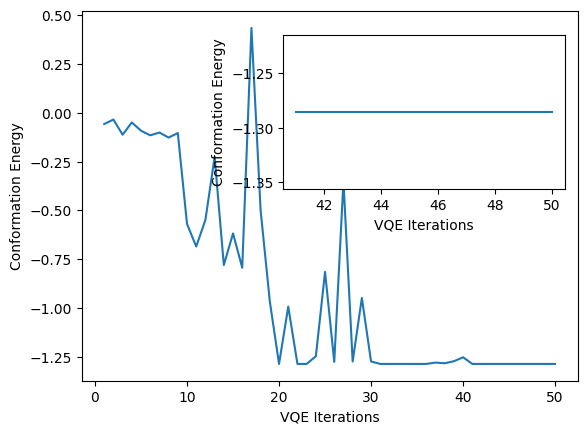

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(counts,values)
plt.ylabel('Conformation Energy')
plt.xlabel('VQE Iterations')

fig.add_axes([0.44,0.51,0.44,0.32])

plt.plot(counts[40:],values[40:])
plt.ylabel('Conformation Energy')
plt.xlabel('VQE Iterations')
plt.show()

In [27]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright